<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/En_passant_Sarah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

2019.2.0.dev0


In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Geometry

L1=10;
L = 10/L1; H = 5/L1;
l0 = 1/L1; w = 2/L1;
L1=(L-w)/2;
L2=(L+w)/2;
H1=H-l0;
epsilon = 0.005; 


plate = Rectangle(Point(0,0), Point(L, H))

notchVertices1 = [Point(L2-epsilon, H), Point(L2 , H1), Point(L2 + epsilon , H)]
notch1 = Polygon(notchVertices1)
notchVertices2 = [Point(L1+epsilon, 0), Point(L1 , l0), Point(L1 - epsilon ,0)]
notch2 = Polygon(notchVertices2)

domain = plate - notch1 - notch2 

cellSize = .03
nel = H / cellSize
mesh   = generate_mesh(domain, nel)


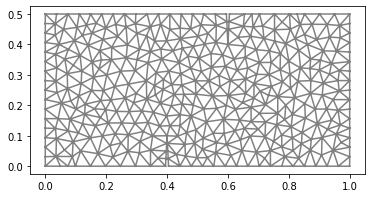

In [12]:
plot(mesh)

In [13]:
ndim = mesh.topology().dim()

cell_mrk = MeshFunction('bool', mesh, ndim)
cell_mrk.set_all(False)

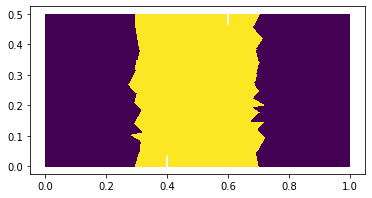

In [14]:
for cell in cells(mesh):
  if 0.3 < cell.midpoint()[0] < 0.7:
    cell_mrk[cell] = True

plot(cell_mrk)

for i in range(2): mesh = refine(mesh, cell_mrk)
# mesh = refine(mesh, cell_mrk)

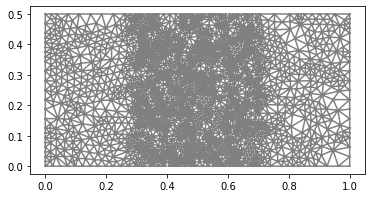

In [15]:
plot(mesh)

In [16]:
V_u = VectorFunctionSpace(mesh, 'CG', 1)
V_alpha = FunctionSpace(mesh, 'CG', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)

alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [19]:
ut = Expression('t', t=0., degree=0)

bcs_u = [DirichletBC(V_u.sub(1), ut, 'near(x[0], {}, 1e-5)'.format(0)), 
         DirichletBC(V_u.sub(1), Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))]



bca_0 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(0))
bca_1 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))

bc_alpha = [bca_0, bca_1]